# 3-a: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



<span style="color:orange;">**The answers to the questions are presented in a more organized manner in the report.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range

    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot

    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [3]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10,10, 10*nbpts)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

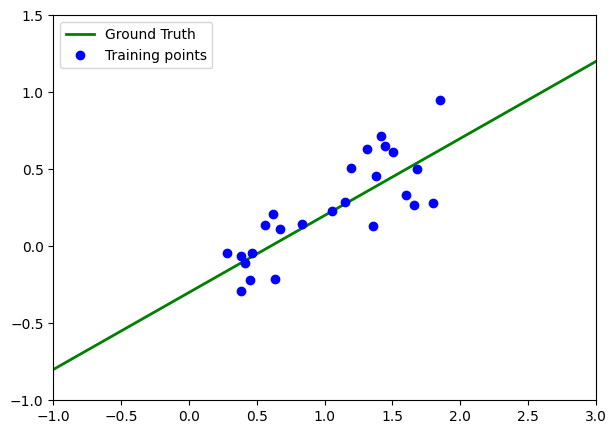

In [4]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [5]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [6]:
#TO DO: Define basis function

# We define the basis function and design matrix at the same time
# and use np.squeeze() when basis function is applied on a single value
def phi_linear(x):
    """ Linear Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) linear features of x
    """
    # TO DO
    phi = np.vstack([np.ones_like(x),x]).T
    return phi

**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

According to the course, we recall that the closed form for the posterior is:
$$p(w|X, Y) = \mathcal{N}(w | \mu, \Sigma)$$
with:
$$\Sigma^{-1} = \alpha I + \beta \Phi^T \Phi$$
$$\mu = \beta \Sigma \Phi^T Y$$

/tmp/ipykernel_1011337/1789710018.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )


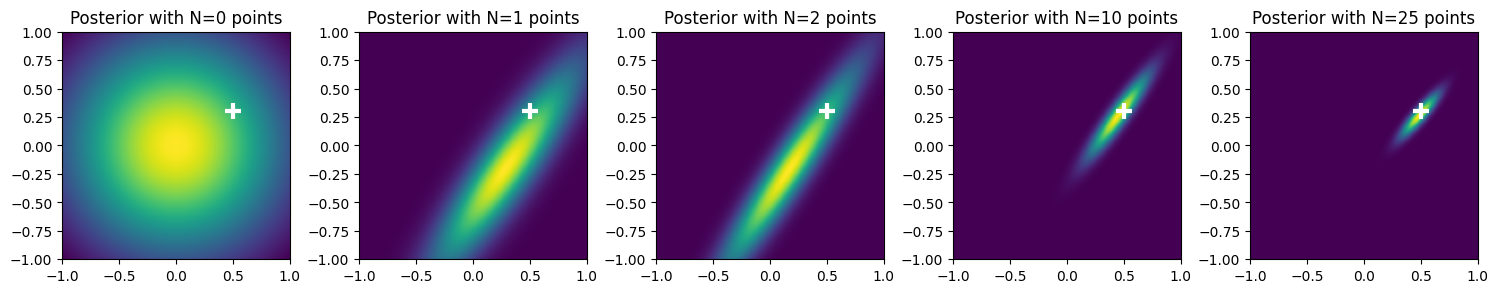

In [7]:
#TO DO: Code and visualize posterior sampling by completing code below
alpha = dataset_linear['ALPHA']
beta = dataset_linear['BETA']

plt.figure(figsize=(15,10))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))

    # TO DO: code mu_N and sigma_N
    if n == 0:
      sigma_N = np.linalg.inv(alpha * np.eye(2))
      mu_N = np.zeros((2, 1))
    else:
      phi = phi_linear(cur_data)
      sigma_N_inv = alpha * np.eye(2) + beta * phi.T @ phi
      sigma_N = np.linalg.inv(sigma_N_inv)
      mu_N = beta * sigma_N @ phi.T @ cur_lbl

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ) )
    posterior[:,:] /= Z

    # Plot posterior with n points
    plt.subplot(151+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
plt.tight_layout()
plt.show()

From this result of posterior sampling, we observe that, initially, with no data, the posterior is broad and uncertain, covering a wide range of values. As data points are added, the posterior becomes more concentrated, aligning with the true parameter values and reducing uncertainty. We conclude that With a higher number of observations, the model's confidence improves, and the variance in parameter estimates shrinks, reflecting a more precise understanding of the underlying relationship.

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

The closed form of the predictive distribution is written as:
$$p(y | x^*, \mathcal{D}, \alpha, \beta) = \mathcal{N}\left(y ; \mu^T \phi(x^*), \frac{1}{\beta} + \phi(x^*)^T \Sigma \phi(x^*) \right)$$

with $\mu$ and $\Sigma$ as defined in question 1.2.

In [8]:
#TO DO: Code closed form solution according to the following requirements defined below

def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter

    Returns:
      (function) prediction function, returning itself both mean and std
    """

    #TO DO
    phi = func(X_train)
    #covariance & expectation of w posteriori
    sigma_inv = alpha * np.eye(phi.shape[1]) + beta * phi.T @ phi
    sigma = np.linalg.inv(sigma_inv)
    mu = beta * sigma @ phi.T @ y_train

    def f_model(x) :
      #variance & mean of predictive distribution
      phi_x = np.squeeze(func(x))
      mean = mu.T @ phi_x
      var = 1/beta + phi_x.T @ sigma @ phi_x
      return mean, np.sqrt(var)

    return f_model

In [9]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

f_pred(1)

(0.22737517646434707, 0.28843788638153744)

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

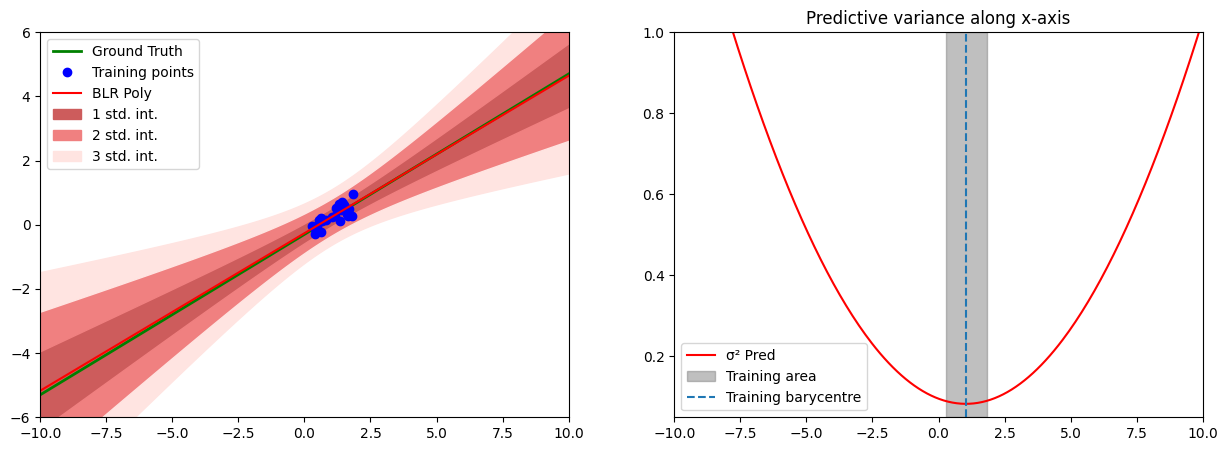

In [10]:
# TO DO : predict on test dataset and visualize results
# You should use the following parameters for plot_results
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1

y_pred, std_pred = np.vectorize(f_pred)(dataset_linear["X_test"])

plot_results(dataset_linear["X_train"],dataset_linear["y_train"],dataset_linear["X_test"],dataset_linear["y_test"],y_pred, std_pred,
                 xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1)

**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

The results reflect the expected influence of training data on model uncertainty. The left plot shows that the model closely fits the ground truth within the training data range, with low uncertainty, while uncertainty increases significantly as the distance from the training data grows. The right plot quantifies this effect, where the predictive variance is minimized near the training data and rises sharply in regions further away. This indicates that the model exhibits higher confidence in well-sampled areas, while in regions with sparse or no data, predictive uncertainty increases.

This phenomenon is more pronounced when $\alpha=0$ and $\beta=1$. In this case, the prior distribution of $w$ approximates a uniform distribution, which is essentially equivalent to having no prior.

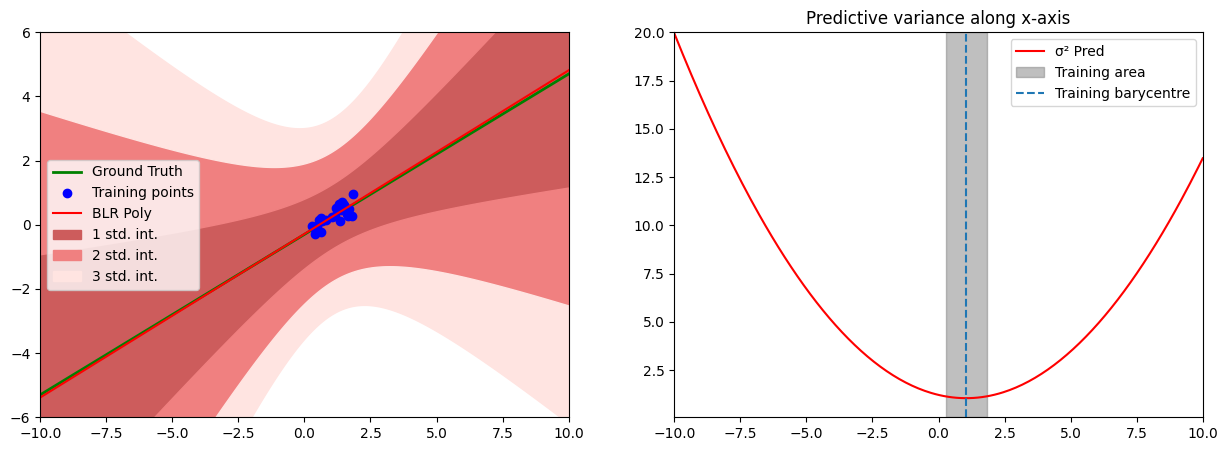

In [11]:
f_pred2 = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     alpha=0, beta=1)

y_pred, std_pred = np.vectorize(f_pred2)(dataset_linear["X_test"])

plot_results(dataset_linear["X_train"],dataset_linear["y_train"],dataset_linear["X_test"],dataset_linear["y_test"],y_pred, std_pred,
                 xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=20)

Analytically, we calculate $\sigma^2_{\text{pred}}(x^*) = \beta^{-1} + \phi(x^*)^T \Sigma \phi(x^*)$ to see what happens:

$$
\Sigma^{-1} = \alpha I + \beta\Phi^T\Phi = \Phi^T\Phi = 
\begin{bmatrix}
    1 & ... & 1 \\
    x_1 & ...& x_N
\end{bmatrix}
\begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_N
\end{bmatrix}  = 
\begin{bmatrix}
    N & \sum_{i=1}^{N} x_i \\
    \sum_{i=1}^{N} x_i & \sum_{i=1}^{N} x^2_i
\end{bmatrix}
$$

By simply inverting $\Sigma^{-1}$, we have:
$$
\Sigma = \frac{1}{|\Sigma^{-1}|}
\begin{bmatrix}
    \sum_{i=1}^{N} x^2_i & -\sum_{i=1}^{N} x_i \\
    -\sum_{i=1}^{N} x_i & N
\end{bmatrix} 
= |\Sigma|
\begin{bmatrix}
    \sum_{i=1}^{N} x^2_i & -\sum_{i=1}^{N} x_i \\
    -\sum_{i=1}^{N} x_i & N
\end{bmatrix} 
$$
Thus, the term $\phi(x^*)^T \Sigma \phi(x^*)$ can be developed as:
$$
\begin{align*}
\phi(x^*)^T \Sigma \phi(x^*) &= |\Sigma|
\begin{bmatrix}
    1 & x^*
\end{bmatrix}
\begin{bmatrix}
    \sum_{i=1}^{N} x^2_i & -\sum_{i=1}^{N} x_i \\
    -\sum_{i=1}^{N} x_i & N
\end{bmatrix}
\begin{bmatrix}
    1 \\ x^*
\end{bmatrix} \\
&= |\Sigma| (\sum_{i=1}^{N} x^2_i - 2x^*\sum_{i=1}^{N} x_i + N{x^*}^2) \\
& = |\Sigma|\sum_{i=1}^{N} (x^2_i - 2x^* x_i + {x^*}^2) \\
& = |\Sigma|\sum_{i=1}^{N} |x^* - x_i|^2
\end{align*}
$$

The expression of $\sigma^2_{\text{pred}}(x^*)$ is now written as:
$$\sigma^2_{\text{pred}}(x^*) = 1 + |\Sigma|\sum_{i=1}^{N} |x^* - x_i|^2$$

This formula indicates that in our specific case, the predictive variance depends on the squared Euclidean distance between each training data point $ x_i $ and the prediction point $ x^* $. As $ x^* $ moves further from the region with concentrated training data, these squared Euclidean distances increase, leading to a corresponding rise in predictive variance.

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

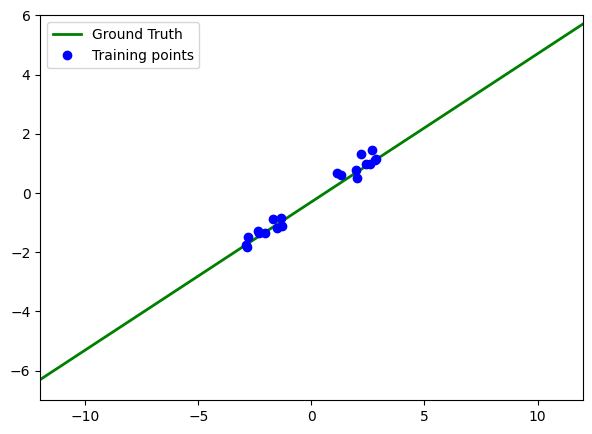

In [12]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

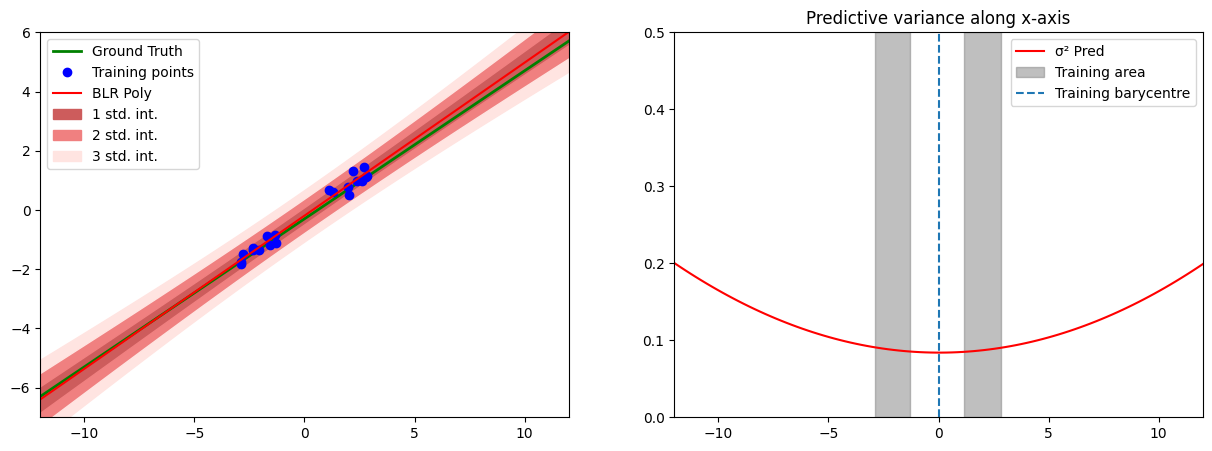

In [13]:
# TO DO: Define f_pred, predict on test points and plot results
# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5

f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'],
                     dataset_hole['ALPHA'], dataset_hole['BETA'])

y_pred, std_pred = np.vectorize(f_pred)(dataset_hole["X_test"])

plot_results(dataset_hole["X_train"],dataset_hole["y_train"],dataset_hole["X_test"],dataset_hole["y_test"],y_pred, std_pred,
                 xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.00, stdmax=0.5)

In the right plot, the predictive variance is observed to decrease and attain the minimum in the central gap between the two data clusters, rather than increasing as might be expected in an area with no data. Analytically,  this is because the sum of the squared distances from this point to all training samples is minimized at the barycenter of the training data which is not in the training area.

Additionally, this also relates to the fact that our basis function is linear, as we have assumed a linear relationship between the input points and their corresponding labels. In a linear model, two points uniquely determine a straight line, which allows the model to confidently interpolate between the clusters. As a result, the predictive variance is minimized in the gap region because the model assumes that the underlying relationship remains linear, leading to a lower perceived uncertainty in that region.

Moreover, the left plot appears more compact compared to the previous ones because $ \frac{1}{\beta} $ has decreased. A lower value of $ \frac{1}{\beta} $ indicates reduced observation noise, leading to tighter confidence intervals around the predicted mean. This implies that the model assigns greater confidence to its predictions, resulting in a narrower spread of uncertainty.

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

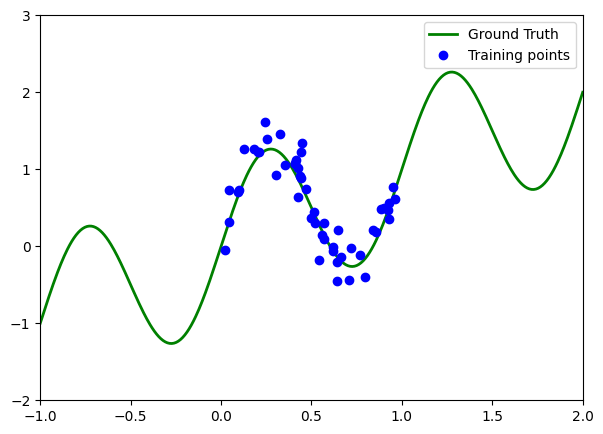

In [14]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)


# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [15]:
# Define basis function

# We define the basis function and design matrix at the same time
# and use np.squeeze() when basis function is applied on a single value

def phi_polynomial(x):
    """ Polynomial Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) polynomial features of x
    """
    D = 10
    # TO DO
    x = np.asarray(x).reshape(-1, 1)
    phi = np.hstack([x**i for i in range(D)])
    return phi

phi_polynomial([0,1,2])

array([[  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,   1,   1,   1,   1,   1,   1,   1,   1],
       [  1,   2,   4,   8,  16,  32,  64, 128, 256, 512]])

**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

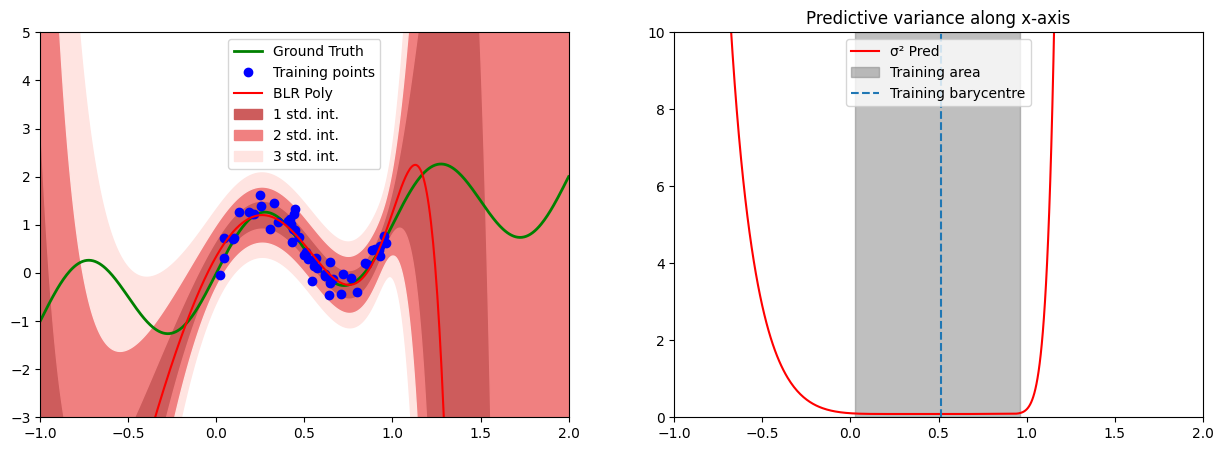

In [16]:
# TO DO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

f_pred = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

y_pred, std_pred = np.vectorize(f_pred)(dataset_sinus["X_test"])

plot_results(dataset_sinus["X_train"],dataset_sinus["y_train"],dataset_sinus["X_test"],dataset_sinus["y_test"],y_pred, std_pred,
                 xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10)

The figure shows that the polynomial basis function model fits well within the training data range but struggles outside this region. In the left plot, the model's predictions closely follow the ground truth within the training area; however, outside this region, the predictions deviate significantly, indicating poor generalization. Additionally, the prediction intervals expand drastically at the boundaries, reflecting a high level of uncertainty. The right plot further confirms this behavior, where the predictive variance is low within the training region but increases sharply beyond it, emphasizing both the model's growing uncertainty and its decreasing accuracy in unseen regions.

**Separate data in Non linear case**

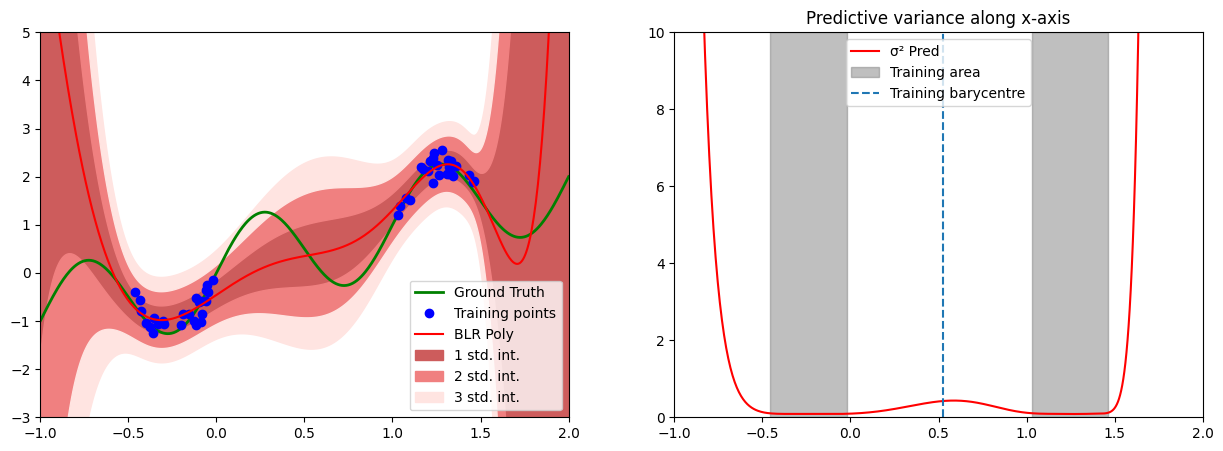

In [17]:
# Non linear dataset with a hole
sigma=0.2
nbpts=50
dataset_hole2 = {}
dataset_hole2['X_train'] = np.concatenate(([np.random.uniform(-0.5, 0, 25), np.random.uniform(1, 1.5, 25)]), axis=0)
dataset_hole2['y_train'] = f_sinus(dataset_hole2['X_train'], noise_amount=1,sigma=sigma)
dataset_hole2['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_hole2['y_test'] = f_sinus(dataset_hole2['X_test'], noise_amount=0,sigma=sigma)

dataset_hole2['ALPHA'] = 0.05
dataset_hole2['BETA'] = 1/(2.0*sigma**2)

f_pred = closed_form(phi_polynomial, dataset_hole2['X_train'], dataset_hole2['y_train'],
                     dataset_hole2['ALPHA'], dataset_hole2['BETA'])

y_pred, std_pred = np.vectorize(f_pred)(dataset_hole2["X_test"])

plot_results(dataset_hole2["X_train"],dataset_hole2["y_train"],dataset_hole2["X_test"],dataset_hole2["y_test"],y_pred, std_pred,
                 xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10)


### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [18]:
#TO DO: Define Gaussian basis function
MU_MIN = 0
MU_MAX = 1
M = 9

# We define the basis function and design matrix at the same time
# and use np.squeeze() when basis function is applied on a single value

def phi_gaussian(x) :
    """ Gaussian Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/M
    x = np.asarray(x).reshape(-1, 1)
    phi = np.hstack([np.exp(-(x - np.arange(MU_MIN, MU_MAX, s)) ** 2 / (2 * s * s))])
    return phi


phi_gaussian([0,1,2])

array([[1.00000000e+00, 6.06530660e-01, 1.35335283e-01, 1.11089965e-02,
        3.35462628e-04, 3.72665317e-06, 1.52299797e-08, 2.28973485e-11,
        1.26641655e-14],
       [2.57675711e-18, 1.26641655e-14, 2.28973485e-11, 1.52299797e-08,
        3.72665317e-06, 3.35462628e-04, 1.11089965e-02, 1.35335283e-01,
        6.06530660e-01],
       [4.40853133e-71, 1.75568810e-63, 2.57220937e-56, 1.38634329e-49,
        2.74878501e-43, 2.00500878e-37, 5.38018616e-32, 5.31109225e-27,
        1.92874985e-22]])

**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

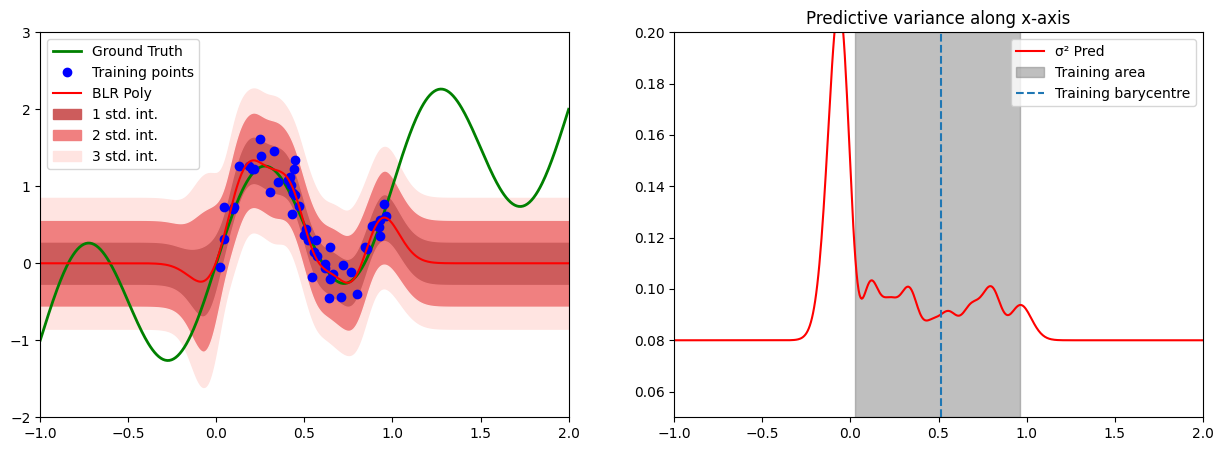

In [19]:
# TO DO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2

f_pred = closed_form(phi_gaussian, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

y_pred, std_pred = np.vectorize(f_pred)(dataset_sinus["X_test"])

plot_results(dataset_sinus["X_train"],dataset_sinus["y_train"],dataset_sinus["X_test"],dataset_sinus["y_test"],y_pred, std_pred,
                 xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)

In the Gaussian basis function model, the predictive variance rapidly increases near the training data boundaries but approaches nearly zero in distant regions. This indicates that the model exhibits overconfidence beyond the training data range, as it fails to align with the ground truth while maintaining an unrealistically low predictive variance. Consequently, the model's uncertainty estimation proves inadequate in areas lacking sufficient training data, leading to overly confident yet inaccurate predictions.

This is because the basis functions we use here produce only local features. In other words, when choosing a point $x^*$ far from $\mu_j$, we have $\phi(x^*) \rightarrow (0,0,...,0)$, causing our prediction to also approach zero, which is not well generalized. This locality prevents the model from properly quantifying uncertainty and leads to a near-zero predictive variance.

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**

This is because the basis functions we use here produce only local features. In other words, when choosing a point $x^*$ far from $\mu_j$, we have $\phi(x^*) \rightarrow (0,0,...,0)$, causing our prediction to also approach zero. This behavior results in poor generalization in data-sparse regions. 

Also, let's recall that when $\phi(x^*) \rightarrow 0$:
$$\sigma^2_{pred} = \beta^{-1} + \phi(x^*)^T \Sigma \phi(x^*) \rightarrow \beta^{-1} \approx 0.08$$
This is coherent with the previous results.
    
To conclude, the locality of the basis function could prevent the model from properly quantifying uncertainty and lead to a near-zero predictive variance.

**Extending the value of $\mu_j$**

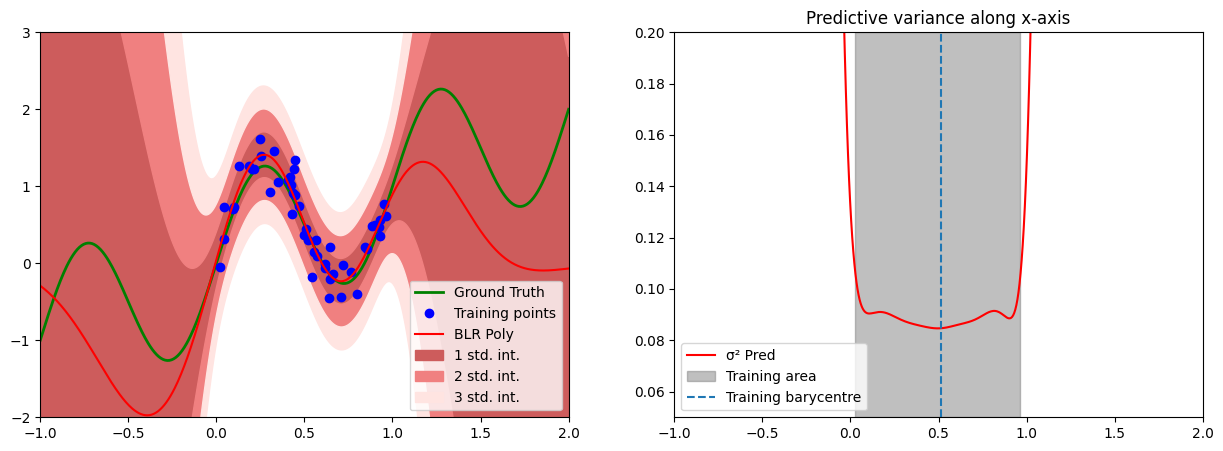

In [20]:
# if we make it look like global
MU_MIN = -2
MU_MAX = 2
M = 15

f_pred = closed_form(phi_gaussian, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

y_pred, std_pred = np.vectorize(f_pred)(dataset_sinus["X_test"])

plot_results(dataset_sinus["X_train"],dataset_sinus["y_train"],dataset_sinus["X_test"],dataset_sinus["y_test"],y_pred, std_pred,
                 xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)